In [18]:
%load_ext autoreload
%autoreload 2

import gymnasium as gym
import numpy as np
from IPython import display
import matplotlib.pyplot as plt

from pid import PID
from energy import Energy
from rso import RSO
from mppi import MPPI

def display_gym(env):
    plt.figure(1)
    plt.clf()
    plt.imshow(env.render())
    plt.axis("off")
    display.display(plt.gcf())
    display.clear_output(wait=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1., 2. Pendulum

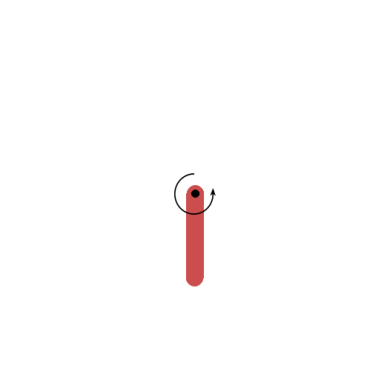

In [19]:
env = gym.make("Pendulum-v1", render_mode="rgb_array", g=9.81)
env.reset()
env.unwrapped.state = np.array([np.pi, 0.0])

for _ in range(100):
    display_gym(env)
    action = np.array([1.0])
    observation, reward, terminated, truncated, info = env.step(action)
env.close()

### 3. PID Controller

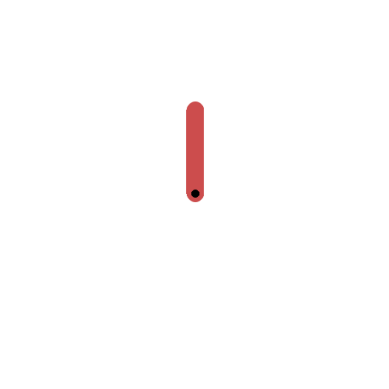

In [20]:
env = gym.make("Pendulum-v1", render_mode="rgb_array", g=9.81)
env.reset()
env.unwrapped.state = np.array([0.1, 0.5])
pid = PID(
    kp=8.0,
    kd=1.0,
    setpoint=0.0,
    dt=env.unwrapped.dt,
)

for _ in range(200):
    display_gym(env)
    theta = env.unwrapped.state[0]
    theta = np.arctan2(np.sin(theta), np.cos(theta))

    u = pid.update(theta)
    observation, reward, terminated, truncated, info = env.step(np.array([u]))
env.close()

### 4. PID with Energy Controller

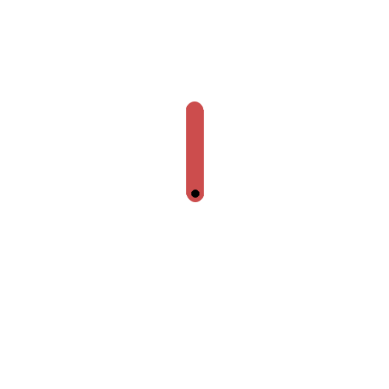

In [21]:
env = gym.make("Pendulum-v1", render_mode="rgb_array", g=9.81)
env.reset()
env.unwrapped.state = np.array([np.pi, 0.0])

dt = env.unwrapped.dt
m = env.unwrapped.m
l = env.unwrapped.l
g = env.unwrapped.g

PID_THRESHOLD = np.pi / 8

pid = PID(kp=8.0, kd=1.0, setpoint=0.0, dt=dt)
energy = Energy(k=2, m=m, g=g, l=l)

for _ in range(200):
    display_gym(env)

    theta = env.unwrapped.state[0]
    dtheta = env.unwrapped.state[1]

    theta = np.arctan2(np.sin(theta), np.cos(theta))  # [-pi, pi]

    if abs(theta) < PID_THRESHOLD:
        u = pid.update(theta)
    else:
        u = energy.update(theta, dtheta)

    observation, reward, terminated, truncated, info = env.step(np.array([u]))

env.close()

### 5. Random Sampling Optimization

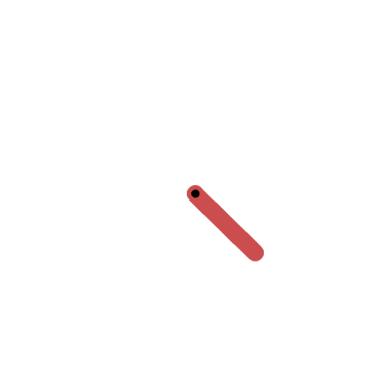

In [22]:
env = gym.make("Pendulum-v1", render_mode="rgb_array", g=9.81)

x0 = np.array([0.0, 0.0])
rso = RSO(
    x0=x0,
    n_iter=2000,
    n_actions=100,
    env=env,
)
actions, reward = rso.optimize()

env.reset()
env.unwrapped.state = x0
for action in actions:
    display_gym(env)
    observation, reward, terminated, truncated, info = env.step(np.array([action]))
env.close()

### 6. Heatmap

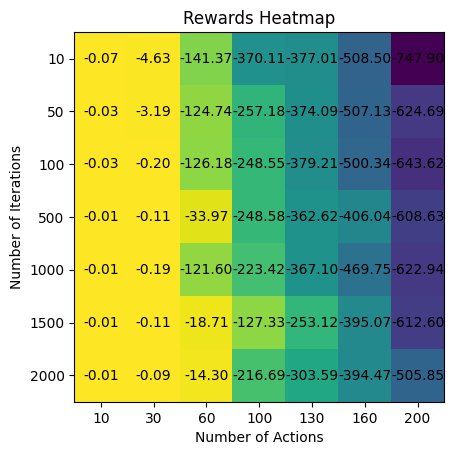

In [23]:
env = gym.make("Pendulum-v1", render_mode="rgb_array", g=9.81)

n_iters = np.array([10, 50, 100, 500, 1000, 1500, 2000])
n_actions = np.array([10, 30, 60, 100, 130, 160, 200])
rewards = np.ndarray((n_iters.size, n_actions.size))
x0 = np.array([0.0, 0.0])

for n_iter in n_iters:
    print(f"n_iter: {n_iter}")
    for n_action in n_actions:
        print(f"    n_action: {n_action}")
        rso = RSO(
            x0=x0,
            n_iter=n_iter,
            n_actions=n_action,
            env=env,
        )
        _, reward = rso.optimize()
        rewards[n_iters == n_iter, n_actions == n_action] = reward
env.close()
display.clear_output()

fig, ax = plt.subplots()
im = ax.imshow(rewards)

ax.set_xticks(np.arange(len(n_actions)))
ax.set_yticks(np.arange(len(n_iters)))

ax.set_xticklabels(n_actions)
ax.set_yticklabels(n_iters)

ax.set_title("Rewards Heatmap")
ax.set_xlabel("Number of Actions")
ax.set_ylabel("Number of Iterations")

for i in range(len(n_iters)):
    for j in range(len(n_actions)):
        text = ax.text(
            j, i, f"{rewards[i, j]:.2f}", ha="center", va="center", color="black"
        )

### 7., 8. MPPI

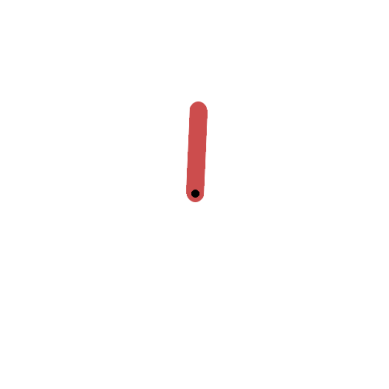

In [25]:
env_options = {"id": "Pendulum-v1", "g": 9.81}
env = gym.make(render_mode="rgb_array", **env_options)
env.reset()
env.unwrapped.state = np.array([0.2, 0.0])

mppi = MPPI(
    horizon=10,
    trajectories=4,
    temperature=0.1,
    noise_cov=np.array([[0.1]]),
    iterations=10,
    env_options=env_options,
)

u = np.zeros((mppi.horizon, 1))

for _ in range(100):
    display_gym(env)
    u = mppi.optimize(x=env.unwrapped.state, u_prev=u)
    observation, reward, terminated, truncated, info = env.step(u[0])

env.close()